In [47]:
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from xgboost import XGBClassifier
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import uniform
from fairlearn.metrics import MetricFrame
from sklearn.metrics import *
from fairlearn.metrics import *
import scipy.stats.distributions as dists
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [48]:
# Set random seeds
seed = 1234
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

In [49]:
path = 'data/census/adult-preprocessed.csv'
file_dataframe = pd.read_csv(path, delimiter=',')

# Columns
IGNORE_COLUMNS = ['is_train']
CATEGORICAL_COLUMNS = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
BIAS_COLUMNS = ['sex', 'race', 'age']
LABEL_COLUMN = "income"
NUMERICAL_COLUMNS = list(set(file_dataframe.columns).difference(set(CATEGORICAL_COLUMNS + [LABEL_COLUMN] + IGNORE_COLUMNS)))

categorical_columns_df = file_dataframe[CATEGORICAL_COLUMNS]
file_dataframe.drop(columns=CATEGORICAL_COLUMNS, inplace=True)
print(file_dataframe.head())

    age    fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
0  39.0   77516.0           13.0        2174.0           0.0            40.0   
1  50.0   83311.0           13.0           0.0           0.0            13.0   
2  38.0  215646.0            9.0           0.0           0.0            40.0   
3  53.0  234721.0            7.0           0.0           0.0            40.0   
4  28.0  338409.0           13.0           0.0           0.0            40.0   

   income  is_train  workclass_?  workclass_Federal-gov  ...  \
0   False       1.0          0.0                    0.0  ...   
1   False       1.0          0.0                    0.0  ...   
2   False       1.0          0.0                    0.0  ...   
3   False       1.0          0.0                    0.0  ...   
4   False       1.0          0.0                    0.0  ...   

   native-country_Portugal  native-country_Puerto-Rico  \
0                      0.0                         0.0   
1                 

In [50]:
# Split the data into train and test
train = file_dataframe[file_dataframe.is_train==True].drop(columns=['is_train'])
test = file_dataframe[file_dataframe.is_train==False].drop(columns=['is_train'])

def min_max_scaling(dataframe):
    scaler = MinMaxScaler()
    for i in NUMERICAL_COLUMNS:
        dataframe[i] = scaler.fit_transform(dataframe[[i]])
    return dataframe
train = min_max_scaling(train)
test = min_max_scaling(test)

# def standard_scaling(dataframe):
#     scaler = StandardScaler()
#     for i in NUMERICAL_COLUMNS:
#         dataframe[i] = scaler.fit_transform(dataframe[[i]])
#     return dataframe
# train = standard_scaling(train)
# test = standard_scaling(test)

# Prepare train set's features and labels
X = train.drop(columns=[LABEL_COLUMN]).to_numpy()
Y = train[LABEL_COLUMN].to_numpy().astype('int')

# Prepare test set's features and labels
X_test = test.drop(columns=[LABEL_COLUMN]).to_numpy()
Y_test = test[LABEL_COLUMN].to_numpy().astype('int')

# Calculate negative positive ratio
negative_positive_ratio = sum(file_dataframe[LABEL_COLUMN] == 0) / sum(file_dataframe[LABEL_COLUMN] == 1)

# Define the classifiers
classifiers = [
    SVC(max_iter=1000, C=1e9, class_weight="balanced"),#SGDClassifier(loss='log', alpha=0.01, max_iter=2000, tol=0, class_weight='balanced'),s
    RandomForestClassifier(class_weight="balanced"),
    XGBClassifier(objective='binary:logistic', scale_pos_weight=negative_positive_ratio, use_label_encoder=False, seed=seed, eval_metric='auc')
    ]

# Define hyperparameters for the classifiers. 
# Note: I did not use hyperparameters since performance is not a focus of the excersise as mentioned by the professor
hyperparameters = [
    dict(C= uniform(0.1, 100), gamma=['scale', 'auto'], kernel=['linear', 'rbf']),
    dict(bootstrap= [True, False], max_features= ['auto', 'sqrt'], max_depth=dists.randint(5, 50), n_estimators= dists.randint(50, 200), min_samples_leaf= [1, 2, 4], min_samples_split= [2, 5, 10]),
    dict(eta=[0.001, 0.1, 0.3, 0.5], min_child_weight=[1, 3, 5], max_depth=dists.randint(5, 50), n_estimators=  dists.randint(50, 200), subsample= [0.5, 0.8, 1.0])
]

# Define the crosss validation strategy
# cv = KFold(n_splits=10)

# Metrics Results
metrics_result = []
output_dir = 'outputs/census'
best_auc, best_Y_pred = 0, None

# Iterate all classifiers
for i in range(len(classifiers)):

    # Select the classifier and its hyperparameters for the experimentation
    classifier = classifiers[i]
    hp = hyperparameters[i]

    # Define the hyperparameter search strategy and find the best model accordingly
    clf = RandomizedSearchCV(classifier, hp, n_iter=30, scoring ='roc_auc', n_jobs=-1, verbose=0)
    search = clf.fit(X, Y)
    best_model = clf.best_estimator_

    # Predict the labels given the test set's features
    Y_pred = best_model.predict(X_test)

    with open(f'{output_dir}/{best_model.__class__.__name__}.npy', 'wb') as f:
        np.save(f, Y_pred)

    # Evaluate the performance of the model based on the test set
    accuracy = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    auc = roc_auc_score(Y_test, Y_pred)
    #roc_curve = RocCurveDisplay.from_predictions(Y_test, Y_pred, name=best_model.__class__.__name__)

    if best_auc < auc:
        best_Y_pred = Y_pred
        best_auc = auc
    
    metrics_result.append('{}: Accuracy: {}, F1: {}, Precision: {}, Recall: {}, AUC: {}'.format(classifier, accuracy, f1, precision, recall, auc))

# Display the performance results
with open(f'{output_dir}/results.txt', 'w') as f:
    for metrics_result in metrics_result:
        f.write(f'{metrics_result}\n')


C:\Users\kevin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [51]:
def plotOccurence(data,colname,label):
    plot=pd.crosstab(index=data[colname],columns=data[label]).plot(kind='bar',stacked=True,figsize=(16,5))
    plt.xlabel(colname)
    plt.ylabel('Count')
    plt.grid(axis='y',linestyle='-')
    plt.title(colname+" vs "+label+" count")

In [52]:
def plotProportion(data,colname,label):
    plot=pd.crosstab(index=data[colname],columns=data[label],normalize='index').plot(kind='bar',stacked=True,figsize=(16,5))
    plt.xlabel(colname)
    plt.ylabel('Proportion')
    plt.grid(axis='y',linestyle='-')
    plt.title(colname+" vs "+label+" proportion")

In [53]:
Y_pred = best_Y_pred
PRED_COLUMN = 'predicted '+ LABEL_COLUMN
preds = pd.DataFrame(Y_pred, columns=[PRED_COLUMN])

file_dataframe = pd.concat([file_dataframe, categorical_columns_df], axis=1)

gold_data = file_dataframe[file_dataframe.is_train==False]
gold_data.reset_index(drop=True, inplace=True)
gold_data[LABEL_COLUMN].replace({False: '<=50K', True: '>50K'}, inplace=True)
gold_data.age = gold_data.age // 10 * 10

pred_data = pd.concat([gold_data, preds], axis=1)
pred_data[PRED_COLUMN].replace({False: '<=50K', True: '>50K'}, inplace=True)

        age    fnlwgt  education-num  capital-gain  capital-loss  \
32561  25.0  226802.0            7.0           0.0           0.0   
32562  38.0   89814.0            9.0           0.0           0.0   
32563  28.0  336951.0           12.0           0.0           0.0   
32564  44.0  160323.0           10.0        7688.0           0.0   
32565  18.0  103497.0           10.0           0.0           0.0   

       hours-per-week  income  is_train  workclass_?  workclass_Federal-gov  \
32561            40.0   False       0.0          0.0                    0.0   
32562            50.0   False       0.0          0.0                    0.0   
32563            40.0    True       0.0          0.0                    0.0   
32564            40.0    True       0.0          0.0                    0.0   
32565            30.0   False       0.0          1.0                    0.0   

       ...  native-country_Vietnam  native-country_Yugoslavia  workclass  \
32561  ...                     0.0      

C:\Users\kevin\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
C:\Users\kevin\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [54]:
def draw_fairlearn_figure(Y_test, Y_pred, data):
    metrics = {
        'accuracy': accuracy_score,
        'f1': f1_score,
        'precision': precision_score,
        'recall': recall_score,
        'false positive rate': false_positive_rate,
        'true positive rate': true_positive_rate,
        'selection rate': selection_rate,
        'count': count}
    metric_frame = MetricFrame(metrics=metrics,
                            y_true=Y_test,
                            y_pred=Y_pred,
                            sensitive_features=data)
    metric_frame.by_group.plot.bar(
        subplots=True,
        layout=[4, 2],
        legend=False,
        figsize=[12, 8],
        title="Show all metrics",
    )

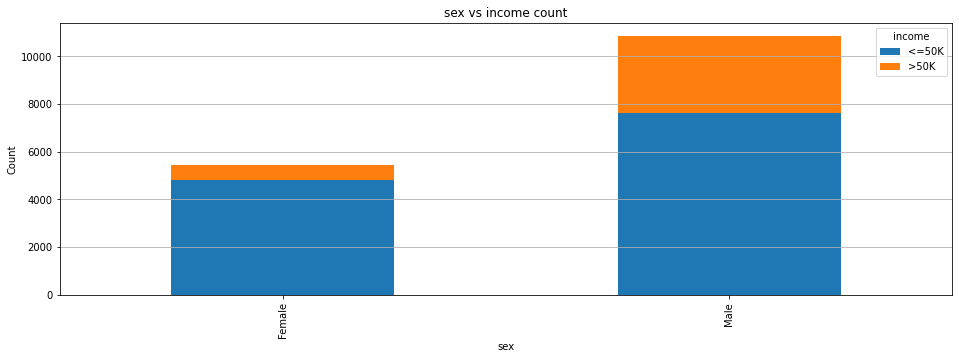

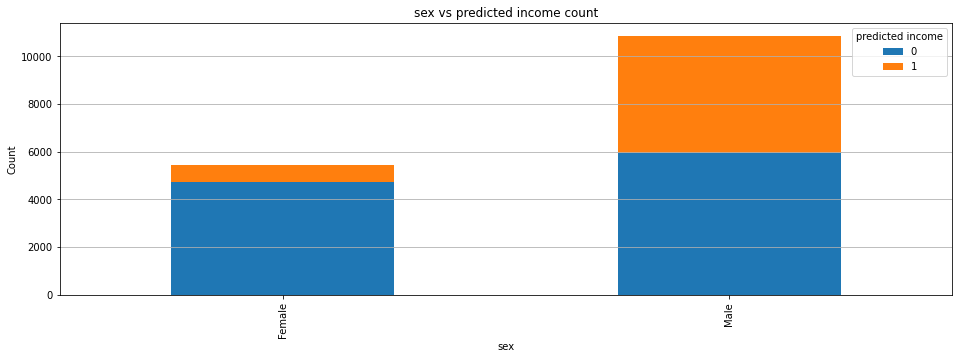

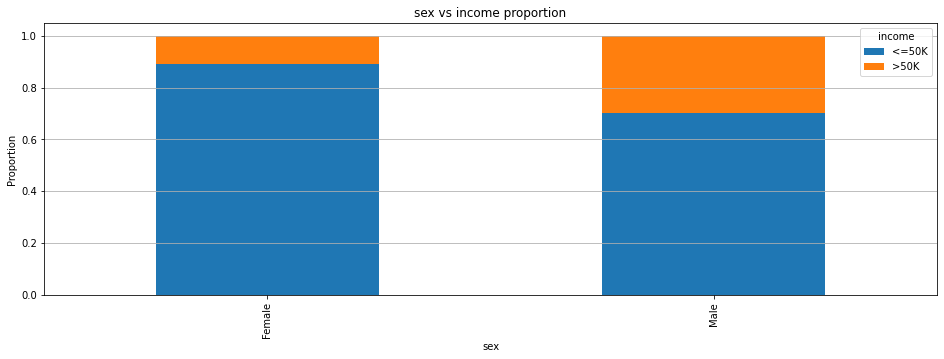

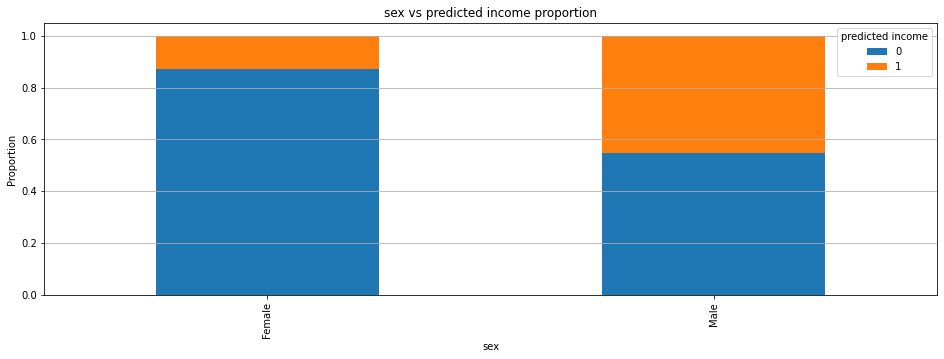

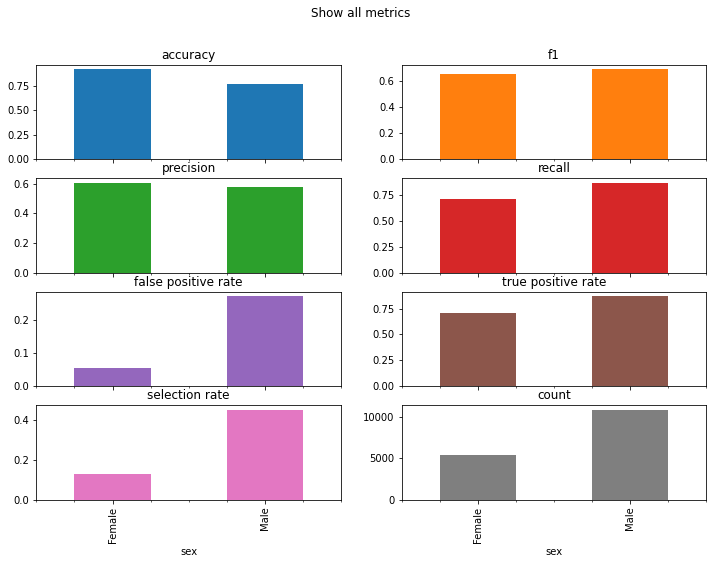

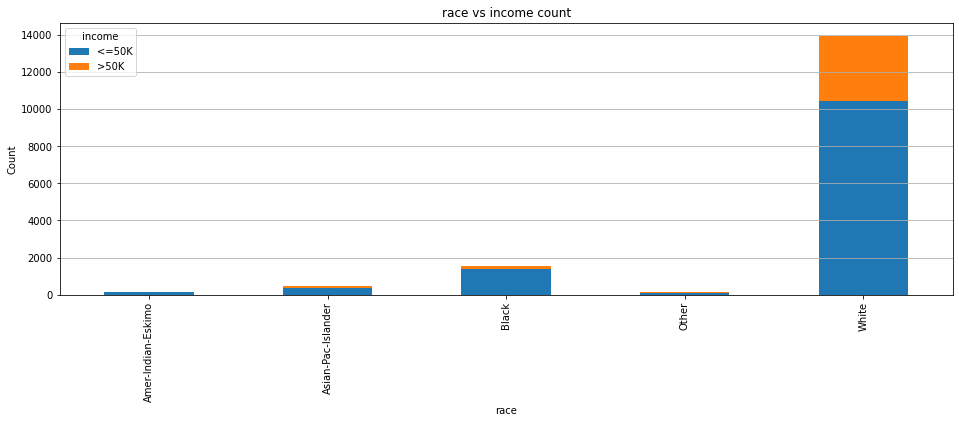

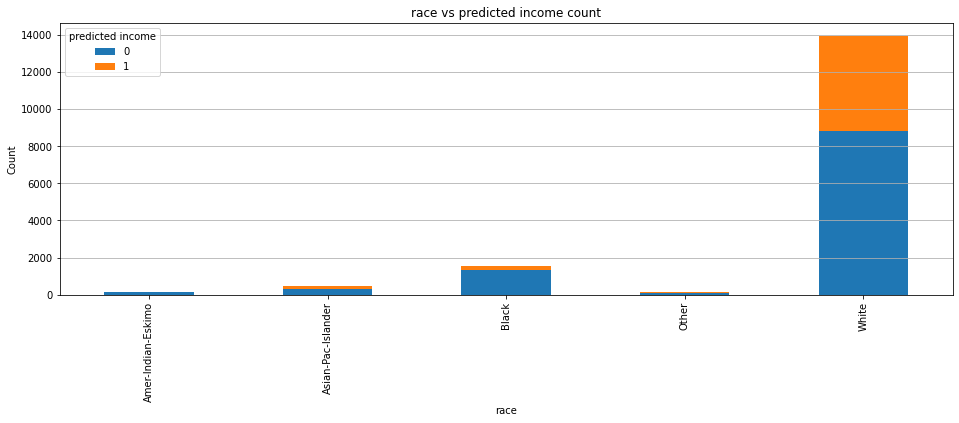

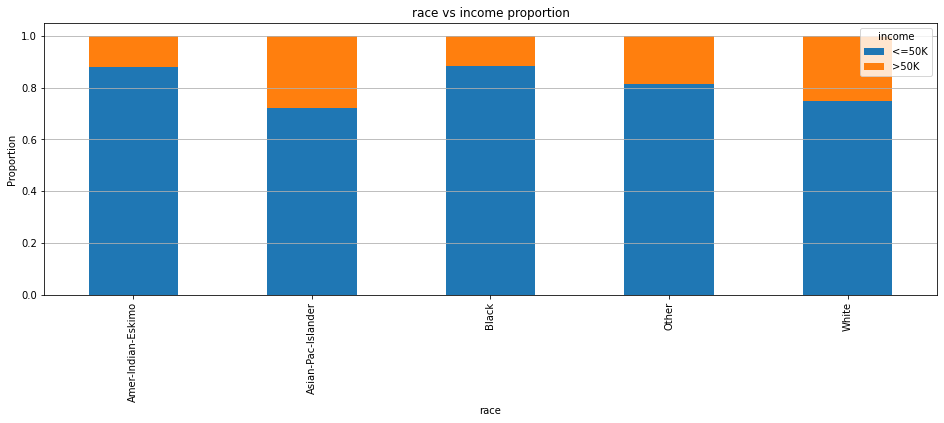

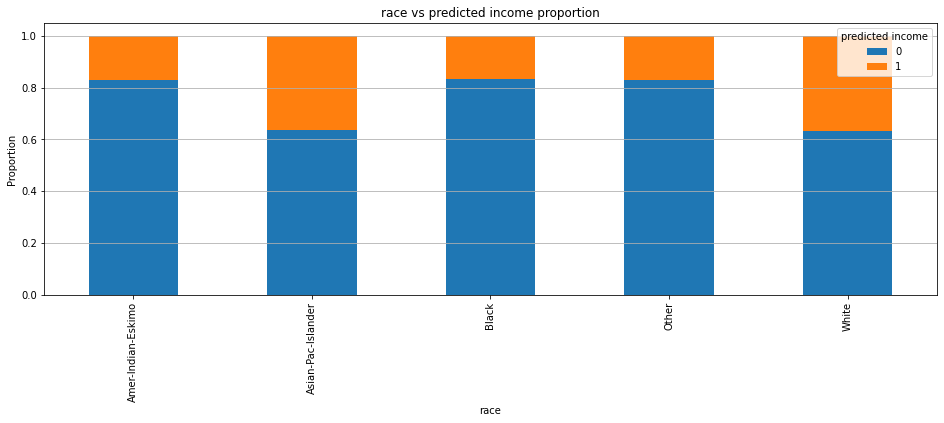

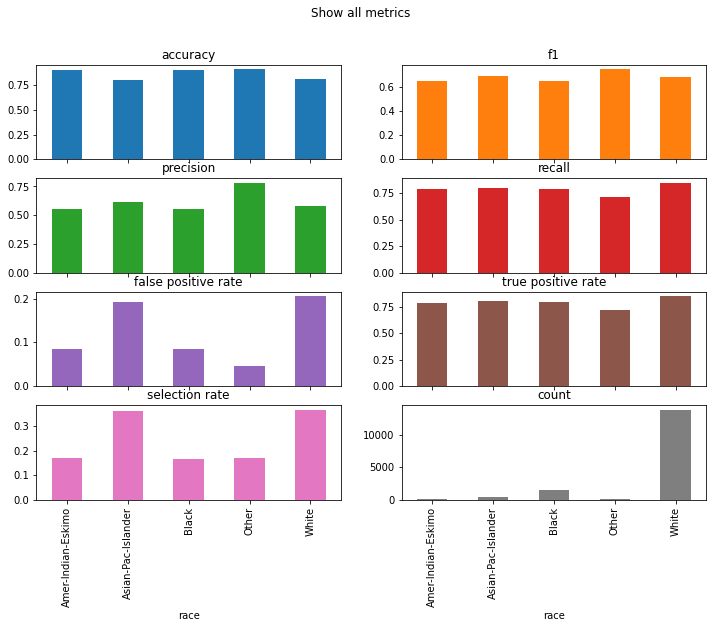

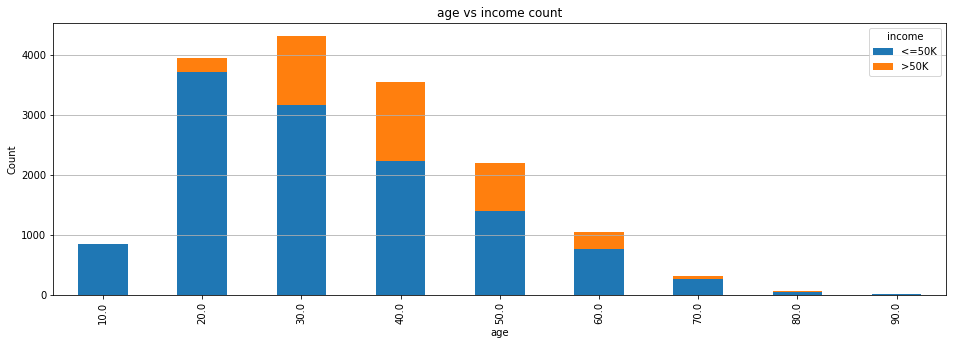

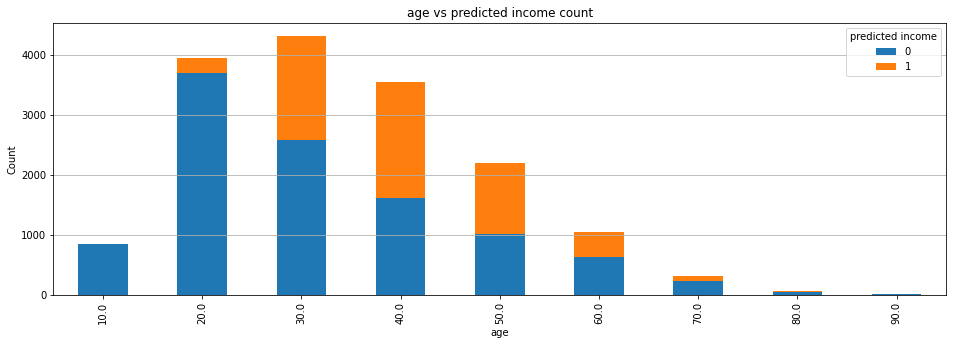

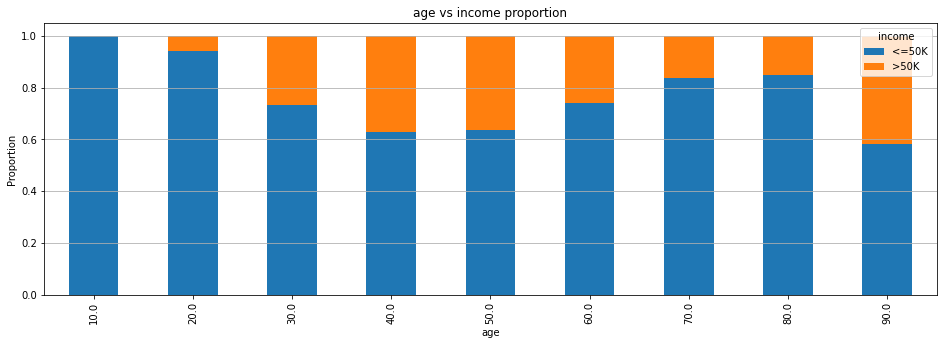

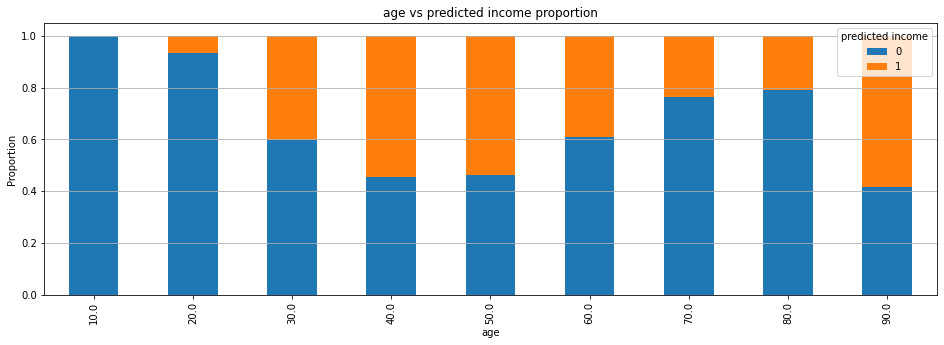

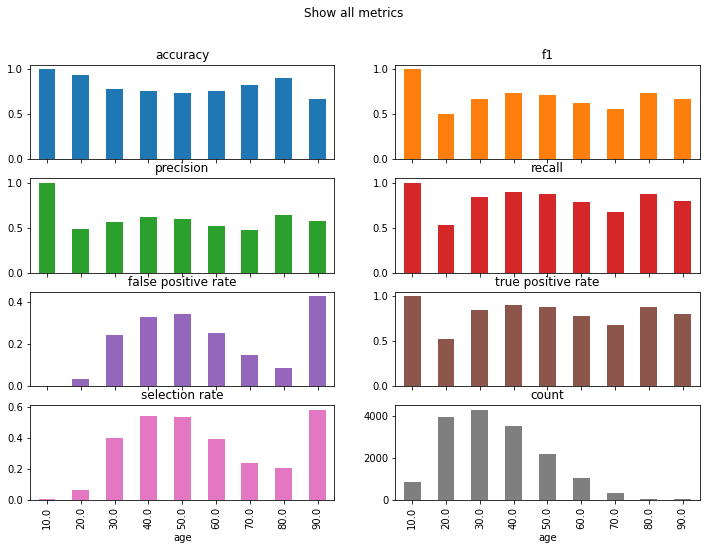

In [55]:
for col in BIAS_COLUMNS:
    plotOccurence(gold_data, col, LABEL_COLUMN)
    plotOccurence(pred_data, col, PRED_COLUMN)
    plotProportion(gold_data, col, LABEL_COLUMN)
    plotProportion(pred_data, col, PRED_COLUMN)
    draw_fairlearn_figure(Y_test, Y_pred, gold_data[col])